## imports

In [1]:
import os
import regex as re
import glob
import unicodedata
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
import json

In [2]:

try:
    from langdetect import detect, LangDetectException, DetectorFactory
    DetectorFactory.seed = 0 
    LANGDETECT_AVAILABLE = True
except ImportError:
    LANGDETECT_AVAILABLE = False
    print("Warning: langdetect library not found. French detection step will be unavailable.")

try:
    import arabic_reshaper
    from bidi.algorithm import get_display
    RTL_DISPLAY_AVAILABLE = True
except ImportError:
    RTL_DISPLAY_AVAILABLE = False
    print("Warning: arabic_reshaper or python-bidi not found. RTL text in plots may not render correctly.")


## read files

In [3]:
def read_corpus_files(directory_path: str) -> str:
    """Reads all .txt files from a directory and concatenates their content."""
    all_text = []
    file_paths = glob.glob(os.path.join(directory_path, "*.txt"))

    if not file_paths:
       
        print(f"Warning: No .txt files found in {directory_path}")
        return ""

    print(f"Found {len(file_paths)} text files in '{directory_path}'.")
    for file_path in tqdm(file_paths, desc="Reading files"):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                all_text.append(f.read())
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    return "\n".join(all_text)

## clean

In [4]:
def clean_text_initial(text: str) -> str:
    """Performs initial cleaning of the text."""
   
    text = re.sub(r'\S+@\S+', ' ', text)
   
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
   
    text = re.sub(r'\[\[File:[^\]]*\]\]', ' ', text)
   
   
    text = re.sub(r'\[\[(?:[^\]]*:|[^\]]*\|[^\]]*)\]\]', ' ', text)
   
    text = re.sub(r'\[\[([^\]]{20,})\]\]', ' ', text)
   
    text = re.sub(r'<.*?>', ' ', text)
   
    text = re.sub(r'\b\d+px\b', ' ', text)
   
    text = unicodedata.normalize('NFKC', text)
   
    text = re.sub(r'\s+', ' ', text).strip()
    return text

## detect french

In [5]:
def detect_and_filter_french_lines(
    lines: list[str],
    french_removal_threshold: float = 0.85,
    min_words_for_check: int = 4
    ) -> list[str]:
    """
    Detects and filters out lines that are predominantly French.
    Keeps lines with mixed content or primarily Arabizi/Darija.
    """
    if not LANGDETECT_AVAILABLE:
        print("Skipping French detection: langdetect library not available.")
        return lines

    kept_lines = []
    removed_count = 0
    print(f"Analyzing {len(lines)} lines for French content...")

    for line in tqdm(lines, desc="Filtering French lines"):
        if not line.strip():
            kept_lines.append(line)
            continue

        words = line.split()
        if len(words) < min_words_for_check:
            kept_lines.append(line)
            continue

        try:
           
            lang = detect(line)
            if lang == 'fr':
               
               
                latin_word_count = 0
                arabizi_signal_present = False
                for word in words:
                    if re.search(r'[a-zA-Z]', word) and not re.search(r'[0-9]', word):
                        latin_word_count += 1
                    if re.search(r'[23579]', word):
                        arabizi_signal_present = True
                
               
               
               
               
               
                
               
               
               
               
                if not any(c in line for c in "23579"):
                    removed_count += 1
                else:
                    kept_lines.append(line)
            else:
               
                kept_lines.append(line)
        except LangDetectException:
           
            kept_lines.append(line)
            
    print(f"Removed {removed_count} lines identified as predominantly French.")
    return kept_lines

## char map

In [6]:
ARABIZI_TO_ARABIC_MAP = {
   
    '2': 'ء', '3': 'ع', '4': 'غ', '6': 'ط', '8': 'ق',
    '7': 'ح', '5': 'خ', '9': 'ق',
                               
   
    'ch': 'ش', 'sh': 'ش', 'kh': 'خ', 'gh': 'غ',
    'th': 'ث', 'dh': 'ذ', 'ou': 'و', 'oo': 'و',
   
    'a': 'ا', 'b': 'ب', 'c': 'س',
    'd': 'د', 'e': 'ي',
    'f': 'ف', 'g': 'ڭ',
    'h': 'ه', 'i': 'ي', 'j': 'ج', 'k': 'ك', 'l': 'ل', 'm': 'م',
    'n': 'ن', 'o': 'و', 'p': 'ب',
    'q': 'ق', 'r': 'ر', 's': 'س',
    't': 'ت', 'u': 'و', 'v': 'ف',
    'w': 'و', 'x': 'كس', 'y': 'ي', 'z': 'ز',
}



## arabize

In [7]:
def arabize_text(text: str) -> str:
    """Converts Arabizi (Latin script Darija with numbers) to Arabic script."""
    text = text.lower()

   
    sorted_keys = sorted(ARABIZI_TO_ARABIC_MAP.keys(), key=len, reverse=True)

    for key in sorted_keys:
        text = text.replace(key, ARABIZI_TO_ARABIC_MAP[key])
    
   
   
   

    return text

## normalize

In [8]:
def normalize_arabic_text(text: str) -> str:
    """Normalizes Arabic script."""
   
    text = re.sub(r'[\u064B-\u065F\u0670]', '', text)
   
    text = text.replace('\u0640', '')
    
   
    text = text.replace('أ', 'ا').replace('إ', 'ا').replace('آ', 'ا').replace('ٱ', 'ا')
    
   
    text = text.replace('ة', 'ه') 
    text = text.replace('ى', 'ي') 
    
   
    text = text.replace('گ', 'ك') 
    text = text.replace('ڭ', 'ك') 
                                 
    text = text.replace('چ', 'ش') 
    text = text.replace('پ', 'ب') 
    text = text.replace('ڤ', 'ف') 
        
    return text

## clean 2

In [9]:
def clean_text_final(text: str, remove_all_numbers: bool = True) -> str:
    """Performs final cleaning, focusing on script and remaining numbers."""
    if remove_all_numbers:
       
        text = re.sub(r'\b\d+\b', ' ', text)
        text = re.sub(r'\b[\u0660-\u0669]+\b', ' ', text)
        text = re.sub(r'\(\d+\)', ' ', text)
        text = re.sub(r'\([\u0660-\u0669]+\)', ' ', text)

   
   
    text = re.sub(r'[^\p{Arabic}\s]', ' ', text, flags=re.UNICODE)
    
   
    text = re.sub(r'\s+', ' ', text).strip()
    return text

## filter short

In [10]:
def filter_short_tokens_from_lines(
    lines: list[str],
    min_token_length: int,
    short_token_allowlist: set = None
    ) -> tuple[list[str], int, int]:
    """
    Filters out tokens shorter than min_token_length from each line,
    unless they are in the allowlist.
    Returns filtered lines and token counts.
    """
    if short_token_allowlist is None:
        short_token_allowlist = set()

    filtered_lines = []
    original_token_count = 0
    final_token_count = 0

    print(f"Filtering tokens shorter than {min_token_length} characters (allowlist: {short_token_allowlist})...")
    for line in tqdm(lines, desc="Filtering short tokens"):
        tokens = line.split()
        original_token_count += len(tokens)
        
        kept_tokens = [
            token for token in tokens
            if len(token) >= min_token_length or token in short_token_allowlist
        ]
        
        final_token_count += len(kept_tokens)
        if kept_tokens: # Only add line if it's not empty after filtering
            filtered_lines.append(" ".join(kept_tokens))
    
    print(f"Original token count (whitespace split): {original_token_count}")
    print(f"Token count after filtering short tokens: {final_token_count}")
    filtered_out_count = original_token_count - final_token_count
    print(f"Filtered out {filtered_out_count} short tokens.")
    
    if not filtered_lines and original_token_count > 0 :
         print("WARNING: All lines became empty after filtering short tokens. Check min_token_length or corpus.")
    return filtered_lines, original_token_count, final_token_count

## train bpe

In [11]:
def train_bpe_tokenizer(
    lines_for_bpe: list[str],
    vocab_size: int,
    min_frequency: int,
    bpe_tokenizer_output_file: str,
    temp_bpe_train_file: str
    ) -> Tokenizer:
    """Trains a BPE tokenizer on the provided lines of text."""
    print(f"Training BPE tokenizer (Vocab Size: {vocab_size}, Min Freq: {min_frequency})...")
    
    with open(temp_bpe_train_file, 'w', encoding='utf-8') as f:
        for line in tqdm(lines_for_bpe, desc="Writing lines for BPE training"):
            f.write(line + '\n')

    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = BpeTrainer(
        vocab_size=vocab_size,
        min_frequency=min_frequency,
        special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
    )
    
    tokenizer.train([temp_bpe_train_file], trainer)
    tokenizer.save(bpe_tokenizer_output_file)
    print(f"BPE Tokenizer trained and saved to {bpe_tokenizer_output_file}")
    
    if os.path.exists(temp_bpe_train_file):
        os.remove(temp_bpe_train_file)
    
    return tokenizer

## apply bpe

In [12]:
def apply_bpe_and_save_corpus(
    lines_to_tokenize: list[str],
    tokenizer_path: str,
    final_tokenized_output_file: str
    ) -> int:
    """Applies a trained BPE tokenizer to lines and saves the tokenized corpus."""
    print(f"Applying BPE tokenizer from {tokenizer_path}...")
    tokenizer = Tokenizer.from_file(tokenizer_path)
    total_bpe_tokens = 0

    with open(final_tokenized_output_file, 'w', encoding='utf-8') as f_out:
        for line in tqdm(lines_to_tokenize, desc="Tokenizing with BPE"):
            if not line.strip():
                continue
            encoding = tokenizer.encode(line)
            bpe_tokens = encoding.tokens
            f_out.write(" ".join(bpe_tokens) + '\n')
            total_bpe_tokens += len(bpe_tokens)
            
    print(f"Finished BPE tokenizing. Saved {total_bpe_tokens} BPE tokens to {final_tokenized_output_file}")
    return total_bpe_tokens

## analyze

In [13]:
def analyze_token_corpus(
    token_source: str | list[str],
    top_n: int = 30,
    is_bpe_corpus: bool = False
    ) -> pd.DataFrame | None:
    """Analyzes token frequencies and lengths from a file or list of tokens."""
    all_tokens = []
    if isinstance(token_source, str):
        print(f"Reading tokens from {token_source} for analysis...")
        try:
            with open(token_source, 'r', encoding='utf-8') as f_in:
                for line in tqdm(f_in, desc="Reading tokens for analysis"):
                    all_tokens.extend(line.strip().split())
        except FileNotFoundError:
            print(f"Error: Could not find {token_source} for analysis.")
            return None
    elif isinstance(token_source, list):
        all_tokens = token_source
    else:
        print("Error: token_source must be a file path or a list of tokens.")
        return None

    if not all_tokens:
        print("Warning: No tokens provided or found for analysis.")
        return None

    corpus_type = "BPE Token" if is_bpe_corpus else "Word Token"
    print(f"Analyzing {len(all_tokens)} {corpus_type.lower()}s...")

    token_freq = {}
    for token in tqdm(all_tokens, desc="Calculating Frequencies"):
        token_freq[token] = token_freq.get(token, 0) + 1

    df = pd.DataFrame.from_dict(token_freq, orient='index', columns=['frequency'])
    df = df.sort_values('frequency', ascending=False).reset_index()
    df.columns = ['token', 'frequency']
    df['length'] = df['token'].apply(len)
    total_token_occurrences = df['frequency'].sum()
    df['rel_frequency'] = df['frequency'] / total_token_occurrences

    print("Generating plots...")
    plt.style.use('seaborn-v0_8-whitegrid')

   
    plt.figure(figsize=(14, 8))
    plot_data = df.head(top_n).copy()
    plot_data['token_str'] = plot_data['token'].astype(str)

   
    if RTL_DISPLAY_AVAILABLE and plot_data['token_str'].apply(lambda x: bool(re.search(r'[\u0600-\u06FF]', x))).any():
        plot_data['token_display'] = plot_data['token_str'].apply(
            lambda x: get_display(arabic_reshaper.reshape(x))
        )
        sns.barplot(x='token_display', y='frequency', data=plot_data, palette="viridis")
    else:
        sns.barplot(x='token_str', y='frequency', data=plot_data, palette="viridis")
    
    plt.title(f'Top {top_n} {corpus_type} Frequencies', fontsize=16)
    plt.xlabel(corpus_type, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=60, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

   
    plt.figure(figsize=(10, 6))
    sns.histplot(df['length'], bins=max(1, df['length'].max()), kde=False, color="skyblue")
    plt.title(f'{corpus_type} Length Distribution', fontsize=16)
    plt.xlabel(f'{corpus_type} Length', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
   
   
    plt.tight_layout()
    plt.show()

    print(f"\nTop {top_n} {corpus_type}s (from analysis):")
    print(df[['token', 'frequency']].head(top_n).to_string())
    print("Analysis complete.")
    return df

## pipeline

In [14]:
def darija_preprocessing_pipeline(
    corpus_dir: str,
    output_dir: str = "processed_darija_corpus",
    sample_size_chars: int | None = None,
    
   
    do_initial_clean: bool = True,
    do_filter_french: bool = True,
    do_arabize: bool = True,
    do_normalize_arabic: bool = True,
    do_final_clean: bool = True,
    do_filter_short_tokens: bool = True,
    do_bpe_tokenize: bool = True,
    do_analyze_final_corpus: bool = True,

   
    french_filter_config: dict | None = None,
    short_token_filter_config: dict | None = None,
    bpe_config: dict | None = None,
    analysis_config: dict | None = None
    ):
    """
    Main pipeline for preprocessing Darija corpus.
    Allows enabling/disabling and configuring each step.
    """
    os.makedirs(output_dir, exist_ok=True)
    print(f"Pipeline started. Output will be in '{output_dir}'")

   
    _french_filter_config = {'french_removal_threshold': 0.85, 'min_words_for_check': 4}
    if french_filter_config: _french_filter_config.update(french_filter_config)

    _short_token_filter_config = {'min_token_length': 2, 'allowlist': {'و', 'في', 'من', 'الى', 'لا', 'ما', 'عن', 'مع'}}
    if short_token_filter_config: _short_token_filter_config.update(short_token_filter_config)
    
    _bpe_config = {'vocab_size': 30000, 'min_frequency': 2}
    if bpe_config: _bpe_config.update(bpe_config)

    _analysis_config = {'top_n': 30}
    if analysis_config: _analysis_config.update(analysis_config)

   
    temp_bpe_train_file = os.path.join(output_dir, "temp_corpus_for_bpe_training.txt")
    bpe_tokenizer_file = os.path.join(output_dir, "darija_bpe_tokenizer.json")
    
    if do_bpe_tokenize:
        final_corpus_path = os.path.join(output_dir, "darija_bpe_tokenized_for_w2v.txt")
    else:
        final_corpus_path = os.path.join(output_dir, "darija_processed_words_for_w2v.txt")

   

   
    print("\n--- Step 1: Reading Corpus ---")
    raw_text = read_corpus_files(corpus_dir)
    if not raw_text:
        print("No text read from corpus. Exiting pipeline.")
        return None, None
    
    if sample_size_chars and len(raw_text) > sample_size_chars:
        print(f"Sampling {sample_size_chars} characters from the corpus.")
        raw_text = raw_text[:sample_size_chars]
    print(f"Initial corpus size: {len(raw_text)} characters.")

    processed_text = raw_text

   
    if do_initial_clean:
        print("\n--- Step 2: Initial Text Cleaning ---")
        processed_text = clean_text_initial(processed_text)
        print(f"Text size after initial cleaning: {len(processed_text)} characters.")

   
    current_lines = processed_text.splitlines()
    current_lines = [line for line in current_lines if line.strip()]

   
    if do_filter_french:
        print("\n--- Step 3: Filtering French Lines ---")
        if not LANGDETECT_AVAILABLE:
            print("Skipping French filtering as langdetect is not available.")
        else:
            current_lines = detect_and_filter_french_lines(
                current_lines,
                **_french_filter_config
            )
            print(f"{len(current_lines)} lines remaining after French filtering.")

   
    processed_text = "\n".join(current_lines)

   
    if do_arabize:
        print("\n--- Step 4: Arabizing Text ---")
        processed_text = arabize_text(processed_text)
        print(f"Text size after arabization: {len(processed_text)} characters.")
       


   
    if do_normalize_arabic:
        print("\n--- Step 5: Normalizing Arabic Script ---")
        processed_text = normalize_arabic_text(processed_text)
        print(f"Text size after Arabic normalization: {len(processed_text)} characters.")
       

   
    if do_final_clean:
        print("\n--- Step 6: Final Text Cleaning ---")
        processed_text = clean_text_final(processed_text, remove_all_numbers=True)
        print(f"Text size after final cleaning: {len(processed_text)} characters.")
       

   
    current_lines = processed_text.splitlines()
    current_lines = [line for line in current_lines if line.strip()]

   
    if do_filter_short_tokens:
        print("\n--- Step 7: Filtering Short Tokens ---")
        current_lines, _, _ = filter_short_tokens_from_lines(
            current_lines,
            min_token_length=_short_token_filter_config['min_token_length'],
            short_token_allowlist=_short_token_filter_config['allowlist']
        )
        print(f"{len(current_lines)} lines remaining after short token filtering.")
        if not current_lines and processed_text:
             print("Warning: No lines remaining after short token filtering. Check configuration or corpus state.")
            
            

   
    if do_bpe_tokenize:
        print("\n--- Step 8: BPE Tokenization ---")
        if not current_lines:
            print("No lines available for BPE training. Skipping BPE.")
            final_corpus_path = None
           
            with open(os.path.join(output_dir, "darija_processed_words_empty.txt"), 'w') as f:
                f.write("")
        else:
            trained_tokenizer = train_bpe_tokenizer(
                current_lines,
                vocab_size=_bpe_config['vocab_size'],
                min_frequency=_bpe_config['min_frequency'],
                bpe_tokenizer_output_file=bpe_tokenizer_file,
                temp_bpe_train_file=temp_bpe_train_file
            )
            _ = apply_bpe_and_save_corpus(
                current_lines,
                bpe_tokenizer_file,
                final_corpus_path
            )
    else:
        print("\n--- Step 8: Saving Word-Tokenized Corpus (BPE Skipped) ---")
        if not current_lines:
            print("No lines available to save for word-tokenized corpus.")
            with open(final_corpus_path, 'w', encoding='utf-8') as f:
                f.write("")
            print(f"Saved empty word-tokenized corpus to {final_corpus_path}")
        else:
            word_count = 0
            with open(final_corpus_path, 'w', encoding='utf-8') as f:
                for line in tqdm(current_lines, desc="Saving word-tokenized corpus"):
                    f.write(line + '\n')
                    word_count += len(line.split())
            print(f"Saved {word_count} words in {len(current_lines)} lines to {final_corpus_path}")

   
    if do_analyze_final_corpus and final_corpus_path and os.path.exists(final_corpus_path) and os.path.getsize(final_corpus_path) > 0:
        print("\n--- Step 9: Analyzing Final Corpus ---")
        analyze_token_corpus(
            final_corpus_path,
            top_n=_analysis_config['top_n'],
            is_bpe_corpus=do_bpe_tokenize
        )
    elif do_analyze_final_corpus:
        print("\n--- Step 9: Analyzing Final Corpus ---")
        print("Skipping analysis: final corpus file is empty or does not exist.")


    print("\n--- Pipeline Finished ---")
    return final_corpus_path, bpe_tokenizer_file if do_bpe_tokenize else None

## main

Pipeline started. Output will be in 'processed_darija_v2'

--- Step 1: Reading Corpus ---
Found 30 text files in 'data'.


Reading files: 100%|██████████| 30/30 [00:03<00:00,  8.73it/s]


Initial corpus size: 619877791 characters.

--- Step 2: Initial Text Cleaning ---
Text size after initial cleaning: 612965540 characters.

--- Step 3: Filtering French Lines ---
Analyzing 1 lines for French content...


Filtering French lines: 100%|██████████| 1/1 [00:32<00:00, 32.60s/it]


Removed 0 lines identified as predominantly French.
1 lines remaining after French filtering.

--- Step 4: Arabizing Text ---
Text size after arabization: 606128321 characters.

--- Step 5: Normalizing Arabic Script ---
Text size after Arabic normalization: 605872876 characters.

--- Step 6: Final Text Cleaning ---
Text size after final cleaning: 584347449 characters.

--- Step 7: Filtering Short Tokens ---
Filtering tokens shorter than 3 characters (allowlist: {})...


Filtering short tokens: 100%|██████████| 1/1 [00:14<00:00, 14.92s/it]


Original token count (whitespace split): 102826433
Token count after filtering short tokens: 81416332
Filtered out 21410101 short tokens.
1 lines remaining after short token filtering.

--- Step 8: BPE Tokenization ---
Training BPE tokenizer (Vocab Size: 35000, Min Freq: 3)...


Writing lines for BPE training: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]





BPE Tokenizer trained and saved to processed_darija_v2/darija_bpe_tokenizer.json
Applying BPE tokenizer from processed_darija_v2/darija_bpe_tokenizer.json...


Tokenizing with BPE: 100%|██████████| 1/1 [07:36<00:00, 456.66s/it]


Finished BPE tokenizing. Saved 117711433 BPE tokens to processed_darija_v2/darija_bpe_tokenized_for_w2v.txt

--- Step 9: Analyzing Final Corpus ---
Reading tokens from processed_darija_v2/darija_bpe_tokenized_for_w2v.txt for analysis...


Reading tokens for analysis: 1it [00:11, 11.94s/it]


Analyzing 117711433 bpe tokens...


Calculating Frequencies: 100%|██████████| 117711433/117711433 [00:30<00:00, 3851304.54it/s]


Generating plots...


/tmp/ipykernel_3055/130974114.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='token_display', y='frequency', data=plot_data, palette="viridis")


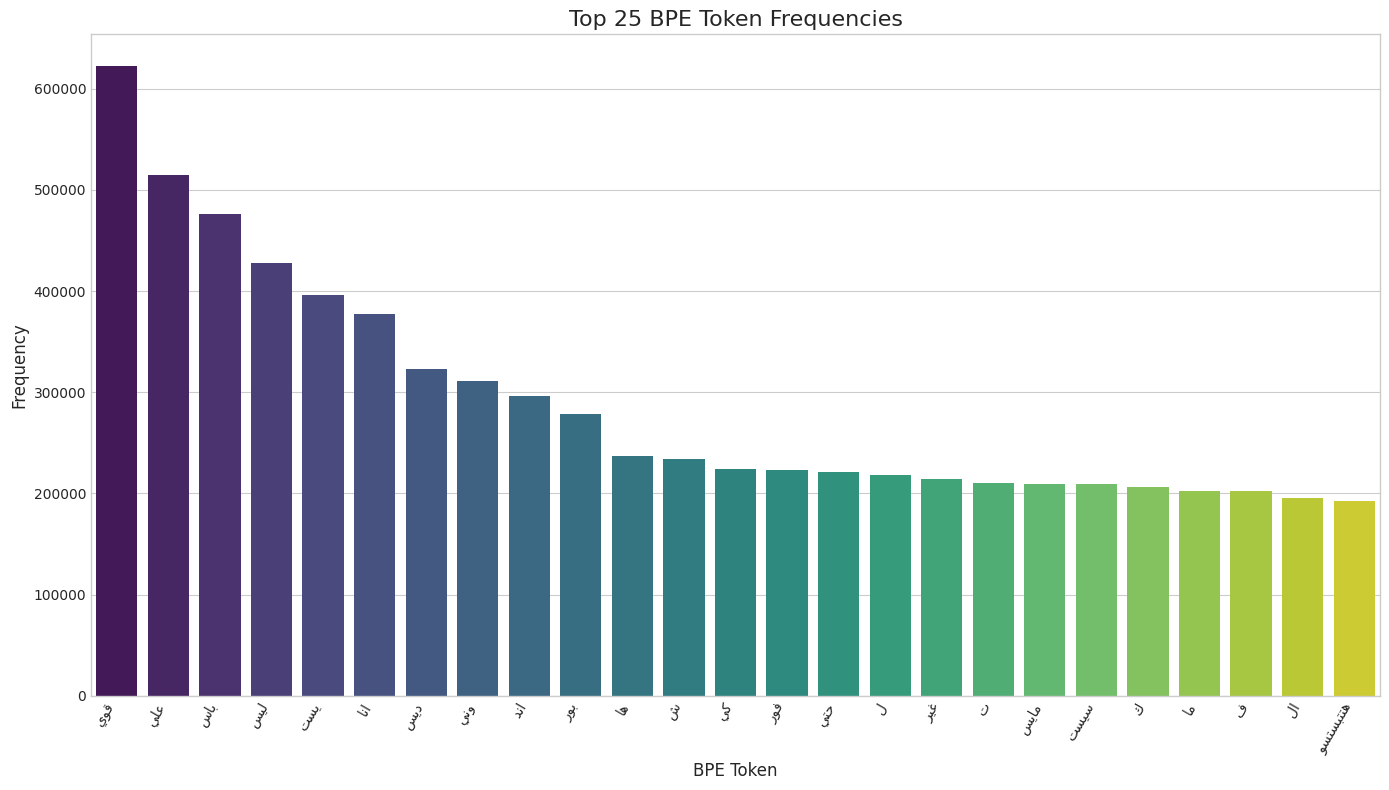

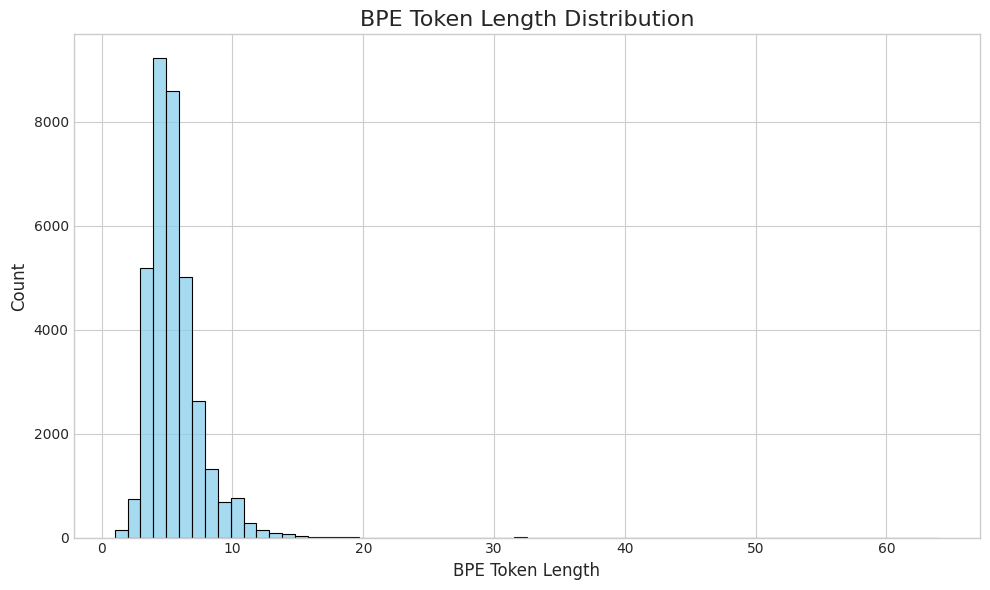


Top 25 BPE Tokens (from analysis):
       token  frequency
0        قوي     622684
1        علي     514670
2        باس     476347
3        ليس     427941
4        يست     396163
5        انا     377160
6        ديس     322903
7        وني     311400
8        اند     296343
9        بور     278204
10        ها     237441
11         ش     234173
12        كي     224010
13       فور     223087
14       حتي     221437
15         ل     218014
16       غير     214032
17         ت     210246
18      مايس     209493
19      سيست     208956
20         ك     206489
21        ما     202297
22         ف     202203
23        ال     195391
24  هتتبستسو     192760
Analysis complete.

--- Pipeline Finished ---

Preprocessing complete.
Final tokenized corpus for Word2Vec: processed_darija_v2/darija_bpe_tokenized_for_w2v.txt
BPE tokenizer model saved to: processed_darija_v2/darija_bpe_tokenizer.json


In [15]:



if __name__ == "__main__":
    CORPUS_DIRECTORY = 'data'
    OUTPUT_DIRECTORY = 'processed_darija_v2'
    
   
    final_file, tokenizer_model = darija_preprocessing_pipeline(
        corpus_dir=CORPUS_DIRECTORY,
        output_dir=OUTPUT_DIRECTORY,
        sample_size_chars=None,
        
        do_initial_clean=True,
        do_filter_french=True,
        do_arabize=True,
        do_normalize_arabic=True,
        do_final_clean=True,
        do_filter_short_tokens=True,
        do_bpe_tokenize=True,
        do_analyze_final_corpus=True,

       
       
        short_token_filter_config={
            'min_token_length': 3,
            'allowlist': {},
           
        },
        bpe_config={'vocab_size': 35000, 'min_frequency': 3},
        analysis_config={'top_n': 25}
    )

    if final_file:
        print(f"\nPreprocessing complete.")
        print(f"Final tokenized corpus for Word2Vec: {final_file}")
        if tokenizer_model:
            print(f"BPE tokenizer model saved to: {tokenizer_model}")
    else:
        print("\nPreprocessing did not produce a final corpus file.")

   
   
   
   
   
   
   
   
   
   